# Emotional Sentiment through Mouse and Keyboard Dynamics
Ryan J Meneses, 2023

## Description
chillpill is an application that collects mouse and keyboard dynamics data from a user and uses it to predict their emotional state. This notebook analyzes the data collected from the application's data collection API and trains linear model to predict the user's emotional state.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from src.util import file

In [2]:
# load all of the datasets into an array
tracking_data = []
tracking_data_names = []
for filename in os.listdir(file.PREPROCESSED_PATH):
    if filename.endswith(".csv"):
        dataset = file.load_preprocessed_file(filename)
        tracking_data.append(dataset)
        tracking_data_names.append(filename)
        print(f"Loaded {filename} with {len(dataset)} rows.")

tracking_data[0].head()

Loaded 20230515-234755.csv with 100001 rows.
Loaded 20230514-005004.csv with 106807 rows.
Loaded 20230511-181507.csv with 100499 rows.
Loaded 20230511-183329.csv with 100000 rows.
Loaded 20230512-144915.csv with 100000 rows.
Loaded 20230515-222326.csv with 101554 rows.
Loaded 20230514-170304.csv with 100001 rows.
Loaded 20230512-025044.csv with 100000 rows.
Loaded 20230518-205930.csv with 100000 rows.
Loaded 20230512-134850.csv with 100011 rows.
Loaded 20230516-225422.csv with 100001 rows.
Loaded 20230510-224440.csv with 108139 rows.
Loaded 20230512-155539.csv with 100002 rows.
Loaded 20230512-015722.csv with 100001 rows.
Loaded 20230511-004806.csv with 100001 rows.
Loaded 20230514-004632.csv with 100004 rows.
Loaded 20230511-170741.csv with 105003 rows.
Loaded 20230512-124723.csv with 100005 rows.
Loaded 20230511-020011.csv with 100001 rows.
Loaded 20230516-143659.csv with 100003 rows.
Loaded 20230517-224102.csv with 100000 rows.


,id,batch,time,x,y,scroll,press,release,feeling,input_type
0,1,1,1.684215e+09,260.535156,180.082031,0,0,0,1,1
1,2,1,1.684215e+09,264.531250,180.082031,0,0,0,1,1
2,3,1,1.684215e+09,269.839844,180.082031,0,0,0,1,1
3,4,1,1.684215e+09,273.835938,180.082031,0,0,0,1,1
4,5,1,1.684215e+09,277.832031,180.082031,0,0,0,1,1


In [3]:
tracking_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100001 non-null  int64  
 1   batch       100001 non-null  int64  
 2   time        100001 non-null  float64
 3   x           100001 non-null  float64
 4   y           100001 non-null  float64
 5   scroll      100001 non-null  int64  
 6   press       100001 non-null  int64  
 7   release     100001 non-null  int64  
 8   feeling     100001 non-null  int64  
 9   input_type  100001 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 7.6 MB


In [4]:
tracking_data[0].describe()

,id,batch,time,x,y,scroll,press,release,feeling,input_type
count,100001.000000,100001.000000,1.000010e+05,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,50000.999950,5.499995,1.684217e+09,463.279894,277.784785,0.194608,0.555154,0.558334,2.000000,1.648324
std,28867.946453,2.872282,1.632797e+03,390.957228,212.788986,0.395901,7.588224,7.608295,0.774597,1.208372
min,1.000000,1.000000,1.684215e+09,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,25001.000000,3.000000,1.684215e+09,73.855469,46.656250,0.000000,0.000000,0.000000,1.000000,1.000000
50%,50001.000000,5.000000,1.684216e+09,426.531250,283.085938,0.000000,0.000000,0.000000,2.000000,1.000000
75%,75001.000000,8.000000,1.684219e+09,771.187500,450.906250,0.000000,0.000000,0.000000,3.000000,1.000000
max,100001.000000,10.000000,1.684220e+09,1279.996094,799.996094,1.000000,122.000000,122.000000,3.000000,4.000000


In [5]:
# value counts of feeling
tracking_data[0]["feeling"].value_counts()

feeling
2    40001
1    30000
3    30000
Name: count, dtype: int64

## New Column and Data Preprocessing

From this point the dataset contains a new `batch` column, that indicates which batch the instances belong to. This batch is associated with a particular `feeling` "post-set" by the user as opposed to being "pre-set" as was initially done.

#### Pre-set vs. Post-set Feeling
Pre-set - the user selects how they are feeling and the feeling is set for each new row instance
Post-set - the user selects how they are feeling after each batch is collected or if they manually set how they're feeling, the program then loops through the entire batch and sets the feeling column.

##### Decision to use post-set over pre-set
Using post-set introduces less bias. During pre-setting, the user described that they felt their behavior change to act as the feeling they set; e.g., if the user said they felt great than they *acted* like they were great for the duration of the batch. In pre-setting, the user must reflect on how they were feeling during the batch that was already collected. 

While there may be minor fluctuations in a users emotional state over, e.g. a batch of 2500 instances, it is assumed that over that batch the feeling is about constant. This could lower the quality of a dataset, but given enough datasets might make up for some of the imprecision. Otherwise, *there may need some preprocessing here to separate good examples from bad.*

### New column: `input_type`
This will help the model distinguish between different kinds of input which could help the model associate different kinds behaviors with the same feeling based on the input type. As a simple example, the user may be more likely to use the mouse when they are feeling happy and more likely to use the keyboard when they are feeling sad. 

### Preprocessing the old datasets to include the new column
The follow code block will add the new column to the old datasets and save them to a new directory. This column will be added by checking the for non-zero values associated with a mouse_motion, mouse_click, keyboard_input, and scrolling event.

`mouse_motion` - associated with `x` and `y` columns
`mouse_click`/`keyboard_click` - currently there is no way to distinguish between as they are both associated with the `press` and `release` columns. So for now they will both be given a keyboard_input value.
`scrolling` - associated with `scroll` column

Encoding
- 1: mouse_motion
- 2: mouse_click
- 3: keyboard_input
- 4: scrolling

In [6]:
# # loop through the dataframe and set input_type to 1 where x or y is not 0, to 3 where press or release is not 0, to 4 where scroll is not 0, or 0 otherwise for all dataframes in the tracking_data array
# for dataframe in tracking_data:
#     for index, row in dataframe.iterrows():
#         if row["x"] != 0 or row["y"] != 0:
#             dataframe.at[index, "input_type"] = 1
#         elif row["press"] != 0 or row["release"] != 0:
#             dataframe.at[index, "input_type"] = 3
#         elif row["scroll"] != 0:
#             dataframe.at[index, "input_type"] = 4
#         else:
#             dataframe.at[index, "input_type"] = 0


# # convert the input_type column to an integer
# for dataframe in tracking_data:
#     dataframe["input_type"] = dataframe["input_type"].astype(int)

# # write all of the dataframes to csv files with the same names in the preprocessed folder
# for dataframe, filename in zip(tracking_data, tracking_data_names):
#     file.write_preprocessed_file_from_dataframe(filename, dataframe)

In [7]:
# show the first 1000 rows of the first dataframe in the tracking_data array
tracking_data[0][:1000]

,id,batch,time,x,y,scroll,press,release,feeling,input_type
0,1,1,1.684215e+09,260.535156,180.082031,0,0,0,1,1
1,2,1,1.684215e+09,264.531250,180.082031,0,0,0,1,1
2,3,1,1.684215e+09,269.839844,180.082031,0,0,0,1,1
3,4,1,1.684215e+09,273.835938,180.082031,0,0,0,1,1
4,5,1,1.684215e+09,277.832031,180.082031,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
995,996,1,1.684215e+09,748.855469,530.117188,0,0,0,1,1
996,997,1,1.684215e+09,752.851562,529.316406,0,0,0,1,1
997,998,1,1.684215e+09,756.847656,529.316406,0,0,0,1,1
998,999,1,1.684215e+09,759.703125,528.601562,0,0,0,1,1


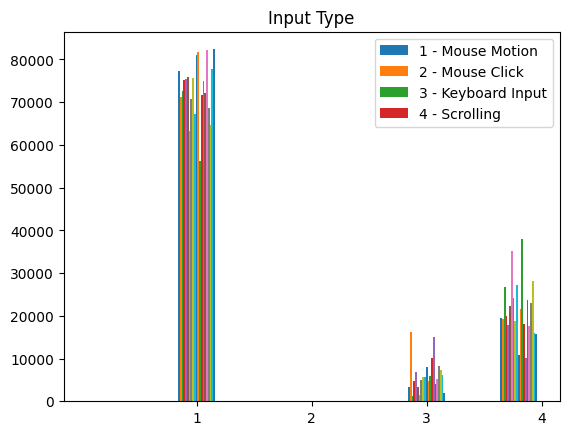

In [8]:
# combine the input_type for all of the dataframes in the tracking_data array into a single histogram
plt.hist([dataframe["input_type"] for dataframe in tracking_data])
plt.xticks(range(1, 5))

plt.title("Input Type")

# add a legend for the input_type values decoded into Mouse Motion, Mouse Click, Keyboard Input, and Scrolling
plt.legend(
    [
        "1 - Mouse Motion",
        "2 - Mouse Click",
        "3 - Keyboard Input",
        "4 - Scrolling",
    ],
)

In [9]:
# separate input_type 1 from the first dataframe in the tracking_data array into a new dataframe
input_type_1 = tracking_data[0][tracking_data[0]["input_type"] == 1]
input_type_1.head()

,id,batch,time,x,y,scroll,press,release,feeling,input_type
0,1,1,1.684215e+09,260.535156,180.082031,0,0,0,1,1
1,2,1,1.684215e+09,264.531250,180.082031,0,0,0,1,1
2,3,1,1.684215e+09,269.839844,180.082031,0,0,0,1,1
3,4,1,1.684215e+09,273.835938,180.082031,0,0,0,1,1
4,5,1,1.684215e+09,277.832031,180.082031,0,0,0,1,1


Text(0.5, 1.0, 'Mouse Motion Feeling')

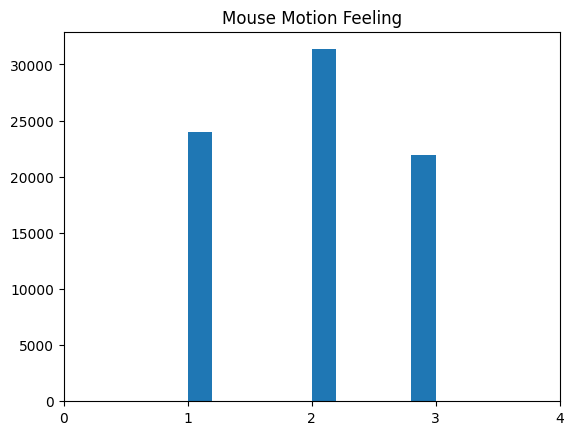

In [10]:
# create a histogram of the input_type 1 dataframe with respect to feeling
plt.hist(input_type_1["feeling"])
plt.xticks(range(5))

plt.title("Mouse Motion Feeling")

In [11]:
# # save input_type 1 dataframe to a csv file in the preprocessed folder with the same name as the original file with mouse-motion- prepended
# file.write_preprocessed_file_by_input_type_from_dataframe(
#     1, "mouse-motion-" + tracking_data_names[0], input_type_1
# )

Text(0, 0.5, 'Y')

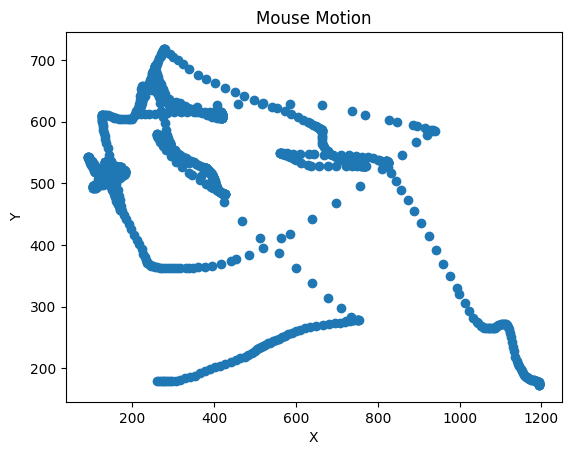

In [12]:
# create an x vs y scatter plot of the input_type 1 dataframe for the first 1000 rows
plt.scatter(
    input_type_1["x"][:1000],
    input_type_1["y"][:1000],
)
plt.title("Mouse Motion")

# label the x and y axes
plt.xlabel("X")
plt.ylabel("Y")

## Experiment no. 1: Training an RNN with GRU Architecture

A RNN (or CNN, planned for later experiments) was chosen for this experiment because it is able to take in a *sequence* of data and output a prediction. This is useful because the data collected is a sequence of events that can be used to predict the user's emotional state. In other words, RNNs can take in variable length sequences. The data corresponding to a particular event in the tracking dataset is not always the same length. For example, if the user is feeling happy they may use the mouse more than the keyboard, which would result in a longer sequence of mouse events than keyboard events.

### Definitions
- RNN (recurrent neural network): RNNs, such as Long Short-Term Memory (LSTM) or Gated Recurrent Unit (GRU), are designed to model sequential data. You can feed a sequence of mouse points to the RNN model, where each point represents a timestamp. The model can learn the temporal dependencies and patterns in the sequence, enabling you to analyze the mouse path and make predictions based on the sequence of points.

- Temporal Dependencies: When data is collected at a high rate, such as mouse motion data, there may be temporal dependencies or patterns within the data that need to be captured. In other words it can consider time series data and has the ability to capture sequential information.

### RNN Overview
- RNN architecture: There are different types of RNN architectures, such as LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit). These architectures are designed to capture long-term dependencies in sequential data. Defining the structure of an RNN model includes specifying the number and type of RNN layers, activation functions, and any additional components such as dropout or recurrent dropout for regularization.

- Build and train an RNN model: Using a deep learning framework like TensorFlow or PyTorch, construct your RNN model. Specify the number of layers, hidden units, and any other relevant hyperparameters. Compile the model with an appropriate loss function and optimizer. Then, train the model using your training data, iterating over the sequences and updating the model's weights based on the prediction errors.

- Amount of data required to train a Recurrent Neural Network (RNN) (or Convolutional Neural Network (CNN)) depends on several factors, including the complexity of the task, the size and diversity of the input data, and the complexity of the network architecture.

#### RNN Architecture
RNN architectures, their structures, and the associated concepts:

- SimpleRNN: SimpleRNN is the basic type of RNN architecture. It consists of a single recurrent layer that processes input sequences one element at a time and maintains a hidden state. SimpleRNN suffers from the vanishing gradient problem, which makes it difficult for the network to learn long-term dependencies in sequences.

- LSTM (Long Short-Term Memory): LSTM is a more advanced type of RNN architecture that addresses the vanishing gradient problem. It introduces a memory cell and three gating mechanisms: the input gate, forget gate, and output gate. These gates control the flow of information, enabling LSTMs to selectively remember or forget information over long sequences. LSTMs are well-suited for tasks that require capturing long-term dependencies.

- GRU (Gated Recurrent Unit): GRU is another variant of the RNN architecture that simplifies the LSTM by combining the forget and input gates into a single "update" gate. It also merges the cell state and hidden state, resulting in a simpler structure compared to LSTM. GRUs are designed to capture long-term dependencies more efficiently than SimpleRNN while having fewer parameters.

- Hidden Units: Hidden units, also known as hidden dimensions or hidden states, refer to the number of neurons or memory cells in the recurrent layer of an RNN. Each hidden unit represents a specific state or memory in the sequence. Increasing the number of hidden units allows the RNN to capture more complex patterns and dependencies but also increases the model's complexity and training time.

- Number of Layers: The number of layers in an RNN refers to the stacking of multiple recurrent layers on top of each other. Deep RNNs with multiple layers can learn more abstract and hierarchical representations of the input data. Each layer processes the output of the previous layer, allowing for increasingly complex feature extraction. Deeper architectures are often used to model complex sequential patterns and achieve better performance, but they also increase the computational cost and the risk of overfitting.

- Activation Functions: Activation functions introduce non-linearity into the RNN, allowing it to model complex relationships. Commonly used activation functions include:

    - Sigmoid: The sigmoid function squashes the output between 0 and 1, making it suitable for gating mechanisms in LSTMs and GRUs. It can be used to control the flow of information and handle binary decision problems.

    - Tanh: The hyperbolic tangent (tanh) function squashes the output between -1 and 1. It is commonly used in RNNs to introduce non-linearity and model a wider range of data.

    - ReLU (Rectified Linear Unit): ReLU is a popular activation function that outputs the input directly if it is positive and 0 otherwise. It helps in mitigating the vanishing gradient problem and speeding up the training process.

    - Softmax: The softmax function is typically used in the final layer of an RNN for multiclass classification problems. It converts the output of the model into probabilities, where each output represents the probability of belonging to a particular class.

### Trials

#### Trial 1
**Hyperparameters**
- input_size = 7  # Number of features
- hidden_size = 64  # Number of hidden units in the GRU layer
- num_layers = 2  # Number of GRU layers
- output_size = 4  # Number of output classes
- learning_rate = 0.001
- num_epochs = 10

**Results**

- Epoch 1/10: Train Loss: 1.0951 | Val Loss: 1.1347 | Accuracy: 32.77%
- Epoch 2/10: Train Loss: 1.0906 | Val Loss: 1.1379 | Accuracy: 32.77%
- Epoch 3/10: Train Loss: 1.0901 | Val Loss: 1.1470 | Accuracy: 32.77%
- Epoch 4/10: Train Loss: 1.0899 | Val Loss: 1.1046 | Accuracy: 32.77%
- Epoch 5/10: Train Loss: 1.0898 | Val Loss: 1.1034 | Accuracy: 32.77%
- Epoch 6/10: Train Loss: 1.0895 | Val Loss: 1.1079 | Accuracy: 32.77%
- Epoch 7/10: Train Loss: 1.0894 | Val Loss: 1.1036 | Accuracy: 32.77%
- Epoch 8/10: Train Loss: 1.0893 | Val Loss: 1.1117 | Accuracy: 32.77%
- Epoch 9/10: Train Loss: 1.0893 | Val Loss: 1.1005 | Accuracy: 32.77%
- Epoch 10/10: Train Loss: 1.0892 | Val Loss: 1.1067 | Accuracy: 32.77%

#### Trial 2
**Hyperparameters**
- input_size = 7  # Number of features
- hidden_size = 128  # Number of hidden units in the GRU layer
- num_layers = 2  # Number of GRU layers
- output_size = 4  # Number of output classes
- learning_rate = 0.001
- num_epochs = 10

**Results**
- Epoch 1/10: Train Loss: 1.0936 | Val Loss: 1.1264 | Accuracy: 32.77%
- Epoch 2/10: Train Loss: 1.0909 | Val Loss: 1.1389 | Accuracy: 32.77%
- Epoch 3/10: Train Loss: 1.0903 | Val Loss: 1.1113 | Accuracy: 32.77%
- Epoch 4/10: Train Loss: 1.0899 | Val Loss: 1.1244 | Accuracy: 32.77%
- Epoch 5/10: Train Loss: 1.0895 | Val Loss: 1.1080 | Accuracy: 32.77%
- Epoch 6/10: Train Loss: 1.0894 | Val Loss: 1.1112 | Accuracy: 32.77%
- Epoch 7/10: Train Loss: 1.0893 | Val Loss: 1.1102 | Accuracy: 32.77%
- Epoch 8/10: Train Loss: 1.0892 | Val Loss: 1.1047 | Accuracy: 32.77%
- Epoch 9/10: Train Loss: 1.0892 | Val Loss: 1.1049 | Accuracy: 32.77%
- Epoch 10/10: Train Loss: 1.0891 | Val Loss: 1.1038 | Accuracy: 32.77%


#### Trial 3
**Hyperparameters**
- input_size = 7  # Number of features
- hidden_size = 128  # Number of hidden units in the GRU layer
- num_layers = 3  # Number of GRU layers
- output_size = 5  # Number of output classes
- learning_rate = 0.01
- num_epochs = 10

**Results**
- Epoch 1/10: Train Loss: 1.0942 | Val Loss: 1.1418 | Accuracy: 32.77%
- Epoch 2/10: Train Loss: 1.0908 | Val Loss: 1.1005 | Accuracy: 32.77%
- Epoch 3/10: Train Loss: 1.0908 | Val Loss: 1.1120 | Accuracy: 32.77%
- Epoch 4/10: Train Loss: 1.0902 | Val Loss: 1.1169 | Accuracy: 32.77%
- Epoch 5/10: Train Loss: 1.0901 | Val Loss: 1.1082 | Accuracy: 32.77%
- Epoch 6/10: Train Loss: 1.0904 | Val Loss: 1.1116 | Accuracy: 32.77%
- Epoch 7/10: Train Loss: 1.0903 | Val Loss: 1.1062 | Accuracy: 32.77%
- Epoch 8/10: Train Loss: 1.0902 | Val Loss: 1.1041 | Accuracy: 32.77%
- Epoch 9/10: Train Loss: 1.0902 | Val Loss: 1.1245 | Accuracy: 32.77%
- Epoch 10/10: Train Loss: 1.0902 | Val Loss: 1.1054 | Accuracy: 32.77%


#### Trial 4
- Increase dataset to 10 dataframes (over 1000000 instances).
- Find validation set that contains 10% of the data with an example of each feeling.

**Hyperparameters**
- input_size = 7  # Number of features
- hidden_size = 64  # Number of hidden units in the GRU layer
- num_layers = 4  # Number of GRU layers
- output_size = 5  # Number of output classes
- learning_rate = 0.01
- num_epochs = 10

**Results**
- Epoch 1/10: Train Loss: 1.1542 | Val Loss: 1.8865 | Accuracy: 20.00%
- Epoch 2/10: Train Loss: 1.1536 | Val Loss: 1.8745 | Accuracy: 20.00%
- Epoch 3/10: Train Loss: 1.1536 | Val Loss: 1.9282 | Accuracy: 20.00%
- Epoch 4/10: Train Loss: 1.1535 | Val Loss: 1.9268 | Accuracy: 20.00%
- Epoch 5/10: Train Loss: 1.1536 | Val Loss: 1.8893 | Accuracy: 20.00%
- Epoch 6/10: Train Loss: 1.1536 | Val Loss: 1.8854 | Accuracy: 20.00%
- Epoch 7/10: Train Loss: 1.1536 | Val Loss: 1.9022 | Accuracy: 20.00%
- Epoch 8/10: Train Loss: 1.1536 | Val Loss: 1.8542 | Accuracy: 20.00%
- Epoch 9/10: Train Loss: 1.1536 | Val Loss: 1.8934 | Accuracy: 20.00%
- Epoch 10/10: Train Loss: 1.1536 | Val Loss: 1.8886 | Accuracy: 20.00%

#### Trial 5
**Hyperparameters**
# Define hyperparameters
- input_size = 7  # Number of features
- hidden_size = 128  # Number of hidden units in the GRU layer
- num_layers = 3  # Number of GRU layers
- output_size = 5  # Number of output classes
- learning_rate = 0.001  # Decreased learning rate for smoother convergence
- num_epochs = 20  # Increased number of epochs for more training iterations

**Results**
- Epoch 1/20: Train Loss: 1.1541 | Val Loss: 1.9028 | Accuracy: 20.00%
- Epoch 2/20: Train Loss: 1.1531 | Val Loss: 1.9109 | Accuracy: 20.00%
- Epoch 3/20: Train Loss: 1.1530 | Val Loss: 1.8788 | Accuracy: 20.00%
- Epoch 4/20: Train Loss: 1.1529 | Val Loss: 1.9064 | Accuracy: 20.00%
- Epoch 5/20: Train Loss: 1.1529 | Val Loss: 1.9084 | Accuracy: 20.00%
- Epoch 6/20: Train Loss: 1.1530 | Val Loss: 1.9100 | Accuracy: 20.00%
- Epoch 7/20: Train Loss: 1.1530 | Val Loss: 1.8949 | Accuracy: 20.00%
- Epoch 8/20: Train Loss: 1.1529 | Val Loss: 1.8877 | Accuracy: 20.00%
- Epoch 9/20: Train Loss: 1.1529 | Val Loss: 1.8962 | Accuracy: 20.00%
- Epoch 10/20: Train Loss: 1.1530 | Val Loss: 1.8895 | Accuracy: 20.00%
- Epoch 11/20: Train Loss: 1.1529 | Val Loss: 1.8986 | Accuracy: 20.00%
- Epoch 12/20: Train Loss: 1.1529 | Val Loss: 1.8938 | Accuracy: 20.00%
... (training stopped, no improvement)

## RNN with GRU Architecture Conclusion
The RNN with GRU architecture was not able to learn the patterns in the data. It was not able to predict the user's emotional state.

This could be due to the following reasons:
- The model is not complex enough to learn the patterns in the data.
- The model is overfitting to the training data.
- The model is not able to learn the patterns in the data because there are no patterns to learn.
- The model is not able to learn the patterns in the data because the data is not labeled correctly.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


# Define the RNN GRU model
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Define dataset class
class TrackingDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe[
            ["time", "x", "y", "scroll", "press", "release", "input_type"]
        ].values
        self.labels = dataframe["feeling"].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.Tensor(self.features[idx]).unsqueeze(
            0
        )  # Add unsqueeze to add a batch dimension
        label = torch.Tensor([self.labels[idx]]).long()
        return feature, label

In [14]:
# Preprocessing and preparing the data
import pandas as pd
from sklearn.model_selection import train_test_split

# combine the first 10 dataframes in the tracking_data as the training data
train_df = pd.concat(tracking_data[:10])
# validation data contains example of all feelings
validation_df = tracking_data[18]

train_dataset = TrackingDataset(train_df)
validation_dataset = TrackingDataset(validation_df)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

# Define hyperparameters
input_size = 7  # Number of features
hidden_size = 128  # Number of hidden units in the GRU layer
num_layers = 3  # Number of GRU layers
output_size = 5  # Number of output classes
learning_rate = 0.001  # Decreased learning rate for smoother convergence
num_epochs = 20  # Increased number of epochs for more training iterations

# Initialize the RNN GRU model
model = RNN_GRU(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()  # Squeeze the labels tensor
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validate the model
    model.eval()
    val_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            labels = labels.squeeze()  # Squeeze the labels tensor
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Print epoch statistics
    train_loss /= len(train_dataset)
    val_loss /= len(validation_dataset)
    accuracy = 100 * total_correct / total_samples
    print(
        f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.2f}%"
    )

Epoch 1/20: Train Loss: 1.1541 | Val Loss: 1.9028 | Accuracy: 20.00%
Epoch 2/20: Train Loss: 1.1531 | Val Loss: 1.9109 | Accuracy: 20.00%
Epoch 3/20: Train Loss: 1.1530 | Val Loss: 1.8788 | Accuracy: 20.00%
Epoch 4/20: Train Loss: 1.1529 | Val Loss: 1.9064 | Accuracy: 20.00%
Epoch 5/20: Train Loss: 1.1529 | Val Loss: 1.9084 | Accuracy: 20.00%
Epoch 6/20: Train Loss: 1.1530 | Val Loss: 1.9100 | Accuracy: 20.00%
Epoch 7/20: Train Loss: 1.1530 | Val Loss: 1.8949 | Accuracy: 20.00%
Epoch 8/20: Train Loss: 1.1529 | Val Loss: 1.8877 | Accuracy: 20.00%
Epoch 9/20: Train Loss: 1.1529 | Val Loss: 1.8962 | Accuracy: 20.00%
Epoch 10/20: Train Loss: 1.1530 | Val Loss: 1.8895 | Accuracy: 20.00%
Epoch 11/20: Train Loss: 1.1529 | Val Loss: 1.8986 | Accuracy: 20.00%
Epoch 12/20: Train Loss: 1.1529 | Val Loss: 1.8938 | Accuracy: 20.00%
